<a href="https://colab.research.google.com/github/camayli/Trabajo-Final-Aprendiza-Autom-tico-II-/blob/main/Modelo_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabajo Final – Aprendizaje Automático II  
**Dataset:** Water Potability (Kaggle)  
**Objetivo:** Clasificación binaria de potabilidad del agua (Potability: 0/1)  
**Flujo:** EDA → Preprocesamiento → Balanceo → Validación (ShuffleSplit estratificado) → Hiperparámetros (Random Search) → Ensembles (Voting) → Comparación final  

> Notebook regenerado automáticamente: 2026-01-01

## 0. Librerías e imports

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, RandomizedSearchCV, cross_validate
from sklearn.metrics import accuracy_score, recall_score, f1_score

from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC

from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.pipeline import Pipeline

from scipy.stats import loguniform, randint

## 1. Carga de datos (KaggleHub)

In [4]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

file_path = "water_potability.csv"
df = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "adityakadiwal/water-potability",
    file_path,
)

df.head()

Using Colab cache for faster access to the 'water-potability' dataset.


,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


## 2. Análisis Exploratorio de Datos (EDA)

In [5]:
print("Shape:", df.shape)
display(df.info())
print("\nDistribución de la variable objetivo (Potability):")
display(df["Potability"].value_counts())

display(df.describe())

Shape: (3276, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


None


Distribución de la variable objetivo (Potability):


,count
Potability,
0,1998
1,1278


,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,2785.000000,3276.000000,3276.000000,3276.000000,2495.000000,3276.000000,3276.000000,3114.000000,3276.000000,3276.000000
mean,7.080795,196.369496,22014.092526,7.122277,333.775777,426.205111,14.284970,66.396293,3.966786,0.390110
std,1.594320,32.879761,8768.570828,1.583085,41.416840,80.824064,3.308162,16.175008,0.780382,0.487849
min,0.000000,47.432000,320.942611,0.352000,129.000000,181.483754,2.200000,0.738000,1.450000,0.000000
25%,6.093092,176.850538,15666.690297,6.127421,307.699498,365.734414,12.065801,55.844536,3.439711,0.000000
50%,7.036752,196.967627,20927.833607,7.130299,333.073546,421.884968,14.218338,66.622485,3.955028,0.000000
75%,8.062066,216.667456,27332.762127,8.114887,359.950170,481.792304,16.557652,77.337473,4.500320,1.000000
max,14.000000,323.124000,61227.196008,13.127000,481.030642,753.342620,28.300000,124.000000,6.739000,1.000000


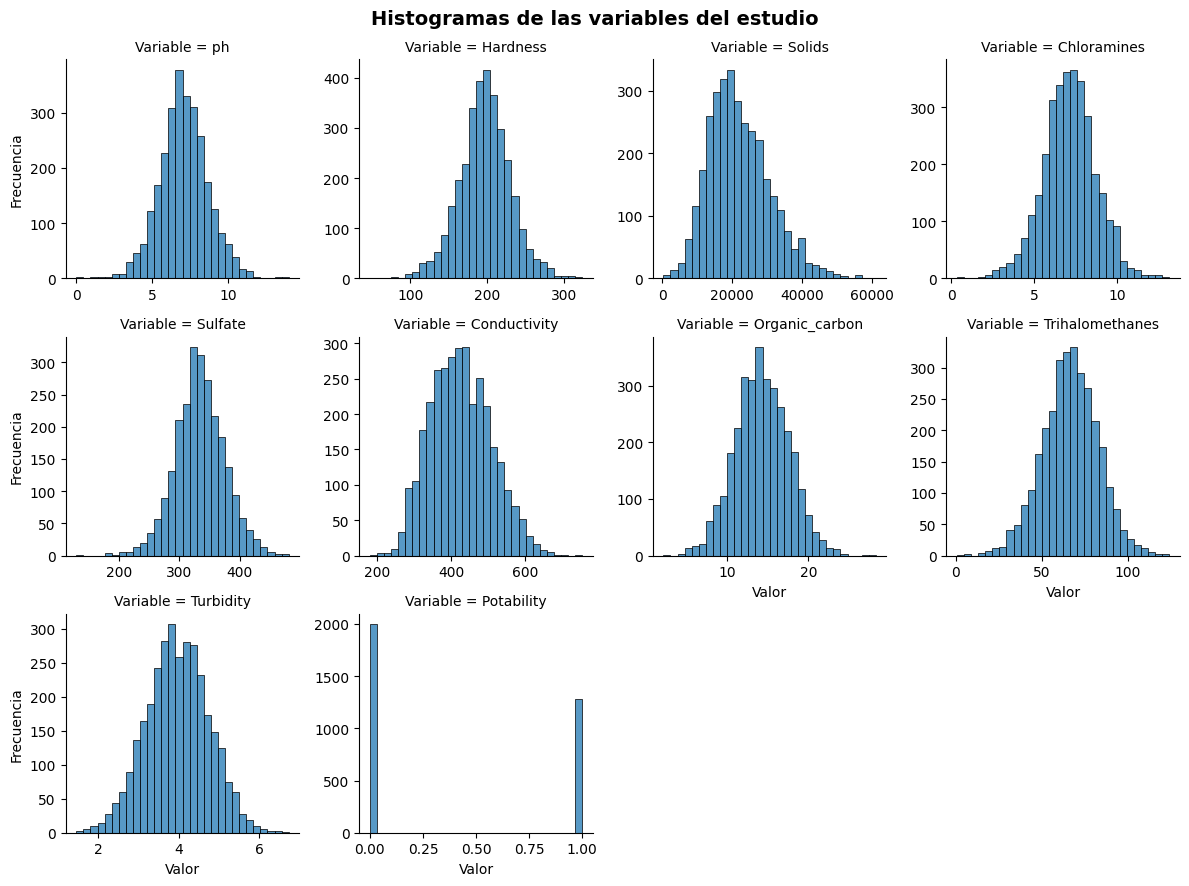

In [6]:
# Histogramas de variables numéricas (incluye Potability al final)
df_num = df.select_dtypes(include="number")
df_long = df_num.melt(var_name="Variable", value_name="Valor")

g = sns.FacetGrid(df_long, col="Variable", col_wrap=4, sharex=False, sharey=False)
g.map_dataframe(sns.histplot, x="Valor", bins=30, edgecolor="black")
g.set_axis_labels("Valor", "Frecuencia")
g.fig.suptitle("Histogramas de las variables del estudio", fontsize=14, fontweight="bold")

plt.tight_layout()
plt.show()

## 3. Preprocesamiento de datos
### 3.1 Separación de variables y Train/Test estratificado

In [ ]:
X = df.drop(columns="Potability")
y = df["Potability"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print("Train:", X_train.shape, "Test:", X_test.shape)
print("\nTarget Train:")
print(y_train.value_counts(normalize=True))
print("\nTarget Test:")
print(y_test.value_counts(normalize=True))

### 3.2 Pipeline base de preprocesamiento + balanceo (para validación / tuning / ensembles)
> **Importante:** Para evitar *data leakage*, el imputado, escalado y oversampling se incluyen dentro del `Pipeline`.

In [ ]:
base_steps = [
    ("imputer", KNNImputer(n_neighbors=7, weights="distance")),
    ("scaler", StandardScaler()),
    ("adasyn", ADASYN(n_neighbors=9, random_state=42))  # balanceo elegido como referencia
]

### 3.3 Balanceo (Hold-out): comparar SMOTE / ADASYN / RandomOverSampler
> Esta sección replica el experimento tipo “rápido” con un solo split Train/Test.  
> Aquí SÍ trabajamos con `X_train`/`X_test` para comparar estrategias de balanceo.

In [ ]:
# Preprocesado manual SOLO para este experimento hold-out (para replicar tu celda original):
scaler = StandardScaler()
imputer = KNNImputer(n_neighbors=7, weights="distance")

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_imp = imputer.fit_transform(X_train_scaled)
X_test_imp = imputer.transform(X_test_scaled)

models_holdout = {
    "LogisticR": LogisticRegression(max_iter=1000, random_state=42),
    "RF": RandomForestClassifier(random_state=42, n_jobs=-1),
    "SVM": SVC()
}

def evaluate_models_full(X_train_bal, y_train_bal, X_test_proc, y_test):
    metrics = {}
    for name, model in models_holdout.items():
        model.fit(X_train_bal, y_train_bal)
        y_pred = model.predict(X_test_proc)
        metrics[f"Accuracy_{name}"] = accuracy_score(y_test, y_pred)
        metrics[f"Recall_{name}"] = recall_score(y_test, y_pred)
        metrics[f"F1_{name}"] = f1_score(y_test, y_pred)
    return metrics

results = []

# SMOTE k=3
smote_3 = SMOTE(k_neighbors=3, random_state=42)
X_s3, y_s3 = smote_3.fit_resample(X_train_imp, y_train)
row = evaluate_models_full(X_s3, y_s3, X_test_imp, y_test)
row["Balanceo"] = "SMOTE_k3"
results.append(row)

# SMOTE k=7
smote_7 = SMOTE(k_neighbors=7, random_state=42)
X_s7, y_s7 = smote_7.fit_resample(X_train_imp, y_train)
row = evaluate_models_full(X_s7, y_s7, X_test_imp, y_test)
row["Balanceo"] = "SMOTE_k7"
results.append(row)

# ADASYN k=5
adasyn_5 = ADASYN(n_neighbors=5, random_state=42)
X_a5, y_a5 = adasyn_5.fit_resample(X_train_imp, y_train)
row = evaluate_models_full(X_a5, y_a5, X_test_imp, y_test)
row["Balanceo"] = "ADASYN_k5"
results.append(row)

# ADASYN k=9
adasyn_9 = ADASYN(n_neighbors=9, random_state=42)
X_a9, y_a9 = adasyn_9.fit_resample(X_train_imp, y_train)
row = evaluate_models_full(X_a9, y_a9, X_test_imp, y_test)
row["Balanceo"] = "ADASYN_k9"
results.append(row)

# RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(X_train_imp, y_train)
row = evaluate_models_full(X_ros, y_ros, X_test_imp, y_test)
row["Balanceo"] = "RandomOver"
results.append(row)

results_df = pd.DataFrame(results).set_index("Balanceo")
print("TABLA FINAL DE RESULTADOS (Hold-out):")
display(results_df)

## 4. Validación – ShuffleSplit (estratificado)
> Se valida con múltiples particiones aleatorias, manteniendo proporción de clases.

In [ ]:
sss = StratifiedShuffleSplit(
    n_splits=20,
    test_size=0.2,
    random_state=42
)

scoring = {"accuracy": "accuracy", "recall": "recall", "f1": "f1"}

In [ ]:
# Modelos individuales (con Pipeline base_steps)
pipe_lr = Pipeline(steps=base_steps + [("model", LogisticRegression(max_iter=1000, random_state=42))])
pipe_rf = Pipeline(steps=base_steps + [("model", RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1))])
pipe_svm = Pipeline(steps=base_steps + [("model", SVC(kernel="rbf", C=1.0, gamma="scale", probability=True))])

cv_lr = cross_validate(pipe_lr, X, y, cv=sss, scoring=scoring, n_jobs=-1)
cv_rf = cross_validate(pipe_rf, X, y, cv=sss, scoring=scoring, n_jobs=-1)
cv_svm = cross_validate(pipe_svm, X, y, cv=sss, scoring=scoring, n_jobs=-1)

print("LR  | Acc: %.3f (± %.3f) | Rec: %.3f (± %.3f) | F1: %.3f (± %.3f)" % (
    cv_lr["test_accuracy"].mean(), cv_lr["test_accuracy"].std(),
    cv_lr["test_recall"].mean(), cv_lr["test_recall"].std(),
    cv_lr["test_f1"].mean(), cv_lr["test_f1"].std()
))
print("RF  | Acc: %.3f (± %.3f) | Rec: %.3f (± %.3f) | F1: %.3f (± %.3f)" % (
    cv_rf["test_accuracy"].mean(), cv_rf["test_accuracy"].std(),
    cv_rf["test_recall"].mean(), cv_rf["test_recall"].std(),
    cv_rf["test_f1"].mean(), cv_rf["test_f1"].std()
))
print("SVM | Acc: %.3f (± %.3f) | Rec: %.3f (± %.3f) | F1: %.3f (± %.3f)" % (
    cv_svm["test_accuracy"].mean(), cv_svm["test_accuracy"].std(),
    cv_svm["test_recall"].mean(), cv_svm["test_recall"].std(),
    cv_svm["test_f1"].mean(), cv_svm["test_f1"].std()
))

## 5. Ajuste de hiperparámetros (RandomizedSearchCV) usando ShuffleSplit estratificado
> **Idea:** probar combinaciones de hiperparámetros y seleccionar la mejor por **F1** bajo el mismo `sss`.

In [ ]:
# Definir modelos base para tuning
models_hp = {
    "LR": LogisticRegression(max_iter=2000, random_state=42),
    "RF": RandomForestClassifier(random_state=42, n_jobs=-1),
    "SVM": SVC(kernel="rbf", probability=True)  # prob=True para soft voting
}

# Espacios de búsqueda
param_spaces = {
    "LR": {
        "model__C": loguniform(1e-3, 1e2),
        "model__penalty": ["l2"],
        "model__solver": ["lbfgs"]
    },
    "RF": {
        "model__n_estimators": randint(150, 500),
        "model__max_depth": randint(3, 25),
        "model__min_samples_split": randint(2, 15),
        "model__min_samples_leaf": randint(1, 10),
        "model__max_features": ["sqrt", "log2"]
    },
    "SVM": {
        "model__C": loguniform(1e-2, 1e2),
        "model__gamma": loguniform(1e-3, 1)
    }
}

best_models = {}
summary_rows = []

for name, model in models_hp.items():
    pipe = Pipeline(steps=base_steps + [("model", model)])

    search = RandomizedSearchCV(
        estimator=pipe,
        param_distributions=param_spaces[name],
        n_iter=30,
        scoring="f1",
        cv=sss,
        random_state=42,
        n_jobs=-1,
        verbose=1
    )
    search.fit(X, y)

    best_models[name] = search.best_estimator_
    summary_rows.append({
        "Modelo": name,
        "Mejor_F1_CV": search.best_score_,
        "Mejores_Params": search.best_params_
    })

resumen_hp = pd.DataFrame(summary_rows).sort_values("Mejor_F1_CV", ascending=False)
display(resumen_hp)

# Guardar referencias directas (para usar en ensembles)
best_lr = best_models["LR"]
best_rf = best_models["RF"]
best_svm = best_models["SVM"]

## 6. Ensembles – Voting HARD y SOFT (con modelos tuneados)
> Se construye el ensemble usando los **modelos ya ajustados** (best_lr/best_rf/best_svm).

In [ ]:
# Extraer estimadores finales (del paso "model") de cada pipeline tuneado
lr_est = best_lr.named_steps["model"]
rf_est = best_rf.named_steps["model"]
svm_est = best_svm.named_steps["model"]  # ya tiene probability=True

voting_hard = VotingClassifier(
    estimators=[("lr", lr_est), ("rf", rf_est), ("svm", svm_est)],
    voting="hard"
)

voting_soft = VotingClassifier(
    estimators=[("lr", lr_est), ("rf", rf_est), ("svm", svm_est)],
    voting="soft"
)

pipe_vhard = Pipeline(steps=base_steps + [("ensemble", voting_hard)])
pipe_vsoft = Pipeline(steps=base_steps + [("ensemble", voting_soft)])

cv_vhard = cross_validate(pipe_vhard, X, y, cv=sss, scoring=scoring, n_jobs=-1)
cv_vsoft = cross_validate(pipe_vsoft, X, y, cv=sss, scoring=scoring, n_jobs=-1)

print("Voting HARD | Acc: %.3f (± %.3f) | Rec: %.3f (± %.3f) | F1: %.3f (± %.3f)" % (
    cv_vhard["test_accuracy"].mean(), cv_vhard["test_accuracy"].std(),
    cv_vhard["test_recall"].mean(), cv_vhard["test_recall"].std(),
    cv_vhard["test_f1"].mean(), cv_vhard["test_f1"].std()
))
print("Voting SOFT | Acc: %.3f (± %.3f) | Rec: %.3f (± %.3f) | F1: %.3f (± %.3f)" % (
    cv_vsoft["test_accuracy"].mean(), cv_vsoft["test_accuracy"].std(),
    cv_vsoft["test_recall"].mean(), cv_vsoft["test_recall"].std(),
    cv_vsoft["test_f1"].mean(), cv_vsoft["test_f1"].std()
))

## 7. Comparación final: modelos vs ensembles (tabla)

In [ ]:
def resumen_cv(name, cv_res):
    return {
        "Modelo": name,
        "Acc_mean": cv_res["test_accuracy"].mean(),
        "Acc_std": cv_res["test_accuracy"].std(),
        "Recall_mean": cv_res["test_recall"].mean(),
        "Recall_std": cv_res["test_recall"].std(),
        "F1_mean": cv_res["test_f1"].mean(),
        "F1_std": cv_res["test_f1"].std()
    }

# Evaluar modelos tuneados con el mismo sss
cv_lr_t = cross_validate(best_lr, X, y, cv=sss, scoring=scoring, n_jobs=-1)
cv_rf_t = cross_validate(best_rf, X, y, cv=sss, scoring=scoring, n_jobs=-1)
cv_svm_t = cross_validate(best_svm, X, y, cv=sss, scoring=scoring, n_jobs=-1)

tabla_final = pd.DataFrame([
    resumen_cv("LR tuned", cv_lr_t),
    resumen_cv("RF tuned", cv_rf_t),
    resumen_cv("SVM tuned", cv_svm_t),
    resumen_cv("Voting HARD", cv_vhard),
    resumen_cv("Voting SOFT", cv_vsoft)
]).sort_values("F1_mean", ascending=False)

display(tabla_final.round(3))